In [31]:
import math
import pandas as pd

import arrow

import ipynb 
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from dotenv import load_dotenv
from networkx.algorithms import bipartite
from importlib import reload

from typing import List

load_dotenv(verbose=True)

True

In [32]:
# import functions from py file 

import function
reload(function)
from function import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from function import nx_dip_graph_from_pandas, plot_bipartite_graph, filter_dict
from function import extract_classes_company_tech, degree_bip, insert_data_classes

In [33]:
# import classes 

import classes
reload(classes)
from classes import Company, Investor, Technology

### Download data from API

In [34]:
query = {
    "field_ids": [
        "name",
        "short_description",
        "location_identifiers",
        "categories",
        "category_groups",
        "facet_ids",
        "twitter",
        "rank_org" 
    ],
    "limit": 1000,
    "query": [
        {
          "type": "predicate",
          "field_id": "location_identifiers",
          "operator_id": "includes",
          "values": ["Switzerland"]
        },
    ]
}

df = df_from_api_CB (query, "organizations")

In [35]:
query = {
    "field_ids": [
        "name",
        "short_description",
        "location_identifiers",
        "categories",
        "category_groups",
        "facet_ids",
        "twitter",
        "rank_org" 
    ],
    "limit": 1000,
}

df = df_from_api_CB (query, "organizations")

Organization download

### Data Cleaning

In [36]:
to_drop = [
    'properties.identifier.image_id',
    'properties.identifier.uuid',
    'properties.identifier.entity_def_id',   
    'properties.short_description',
    'properties.identifier.permalink',
    'properties.short_description',
    'properties.twitter.value',
    'properties.categories'
]

to_rename = {
    'properties.name': 'name', 
    'properties.category_groups':'category_groups',
    'properties.location_identifiers': 'location_comp',
    'properties.rank_org': 'rank_company'
}

to_check_double = {
    'name': 'properties.identifier.value'
    
}

sort_by = "rank_company"

In [37]:
df = CB_data_cleaning(df, to_drop, to_rename, to_check_double, sort_by)

### Extract categories:

In [38]:
df["category_groups"] = extract_data_from_column(df["category_groups"], 'value')

In [39]:
df.head()

uuid       name       properties.facet_ids  \
0  1a410398-3a72-5882-99b8-6318cf594850   SoftBank  [investor, company, rank]   
1  a144cec4-7a73-c500-e162-6fd608aab4d5    Compass            [company, rank]   
2  a40d0a1f-f32c-a1e9-1bbd-a10bb0eca2e7  Deliveroo            [company, rank]   
3  468bef9f-2f50-590e-6e78-62e3adb05aa1  Citigroup  [investor, company, rank]   
4  022417b5-4980-6c54-0f3c-6736bbbb1a5e    Spotify  [investor, company, rank]   

                                     category_groups  rank_company  \
0  [Financial Services, Hardware, Internet Servic...             1   
1                                      [Real Estate]             2   
2  [Administrative Services, Food and Beverage, T...             3   
3  [Financial Services, Lending and Investments, ...             4   
4  [Content and Publishing, Internet Services, Me...             5   

                                       location_comp  
0  [{'permalink': 'tokyo-tokyo', 'uuid': '127ba62...  
1  [{'permalink': 'new-york-new-york', 'uuid': 'd...  
2  [{'permalink': 'london-england', 'uuid': 'aad1...  
3  [{'permalink': 'new-york-new-york', 'uuid': 'd...  
4  [{'permalink': 'stockholm-stockholms-lan', 'uu...

### Create Companies and Technologies classes

In [ ]:
[dict_companies, dict_tech, B] = extract_classes_company_tech(df)

In [41]:
print(f"We have {len(dict_companies)} companies and {len(dict_tech)} technologies")

We have 999 companies and 47 technologies


### Plots

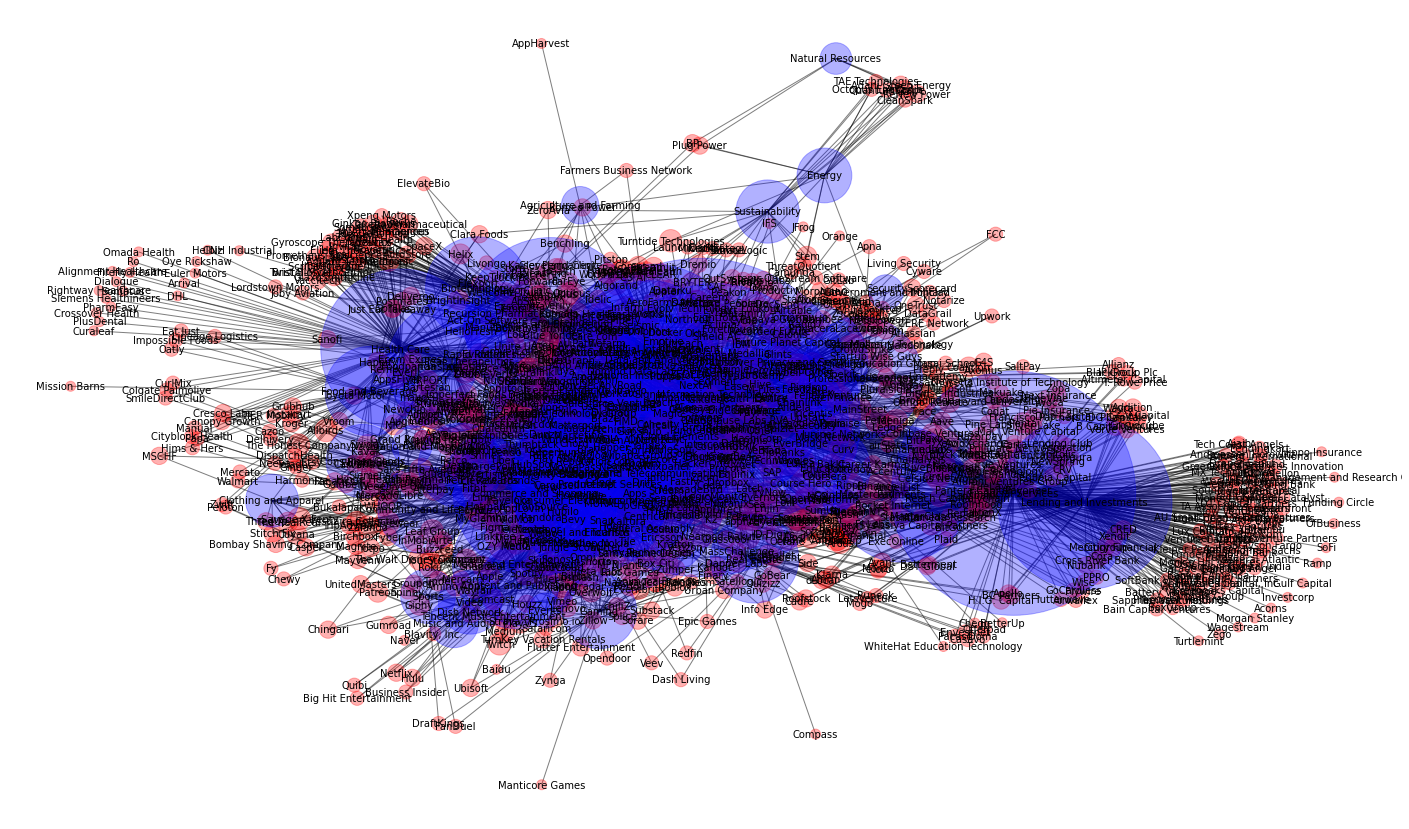

In [42]:
plot_bipartite_graph(B, small_degree=True)

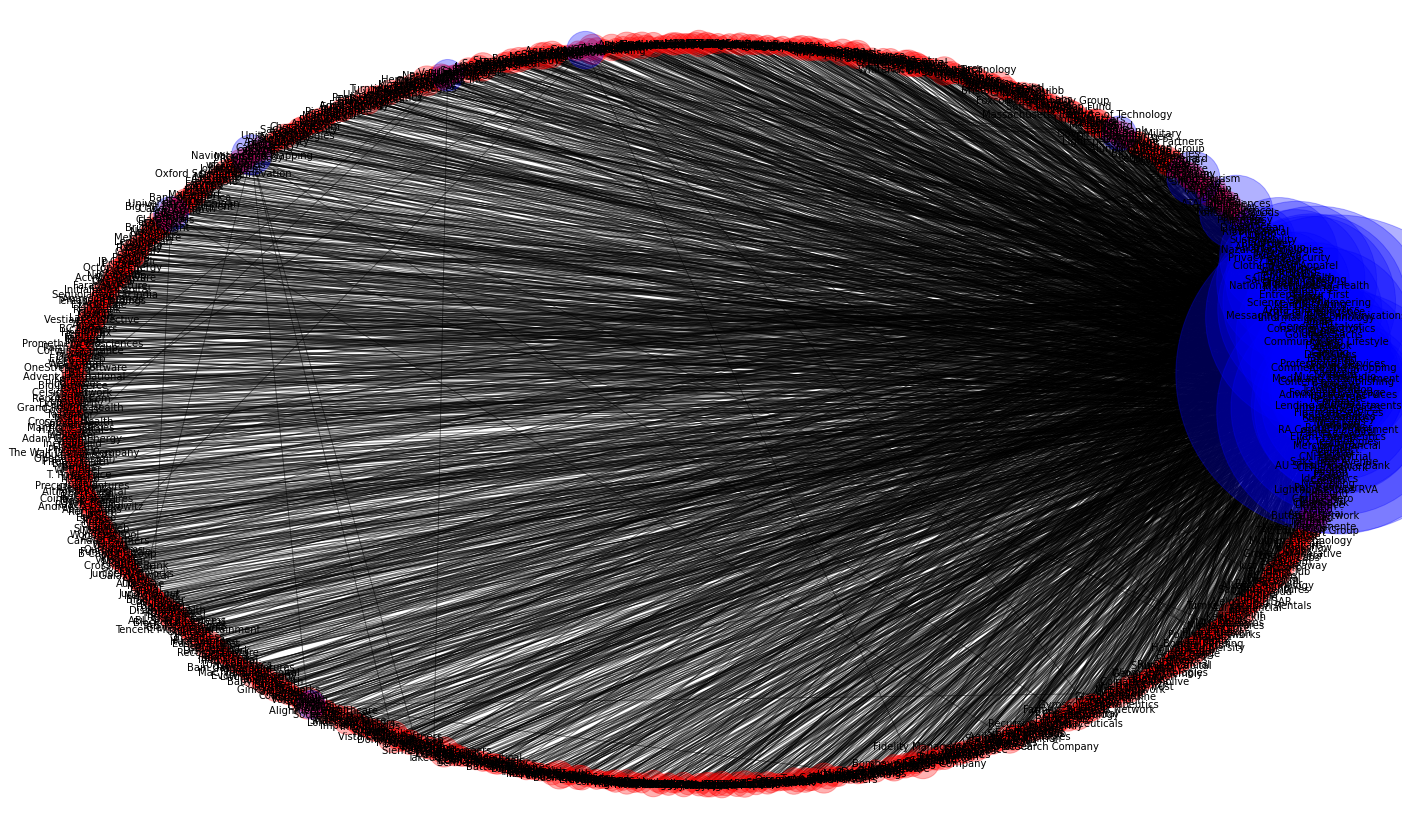

In [43]:
plot_bipartite_graph(B, small_degree=True, circular=True)

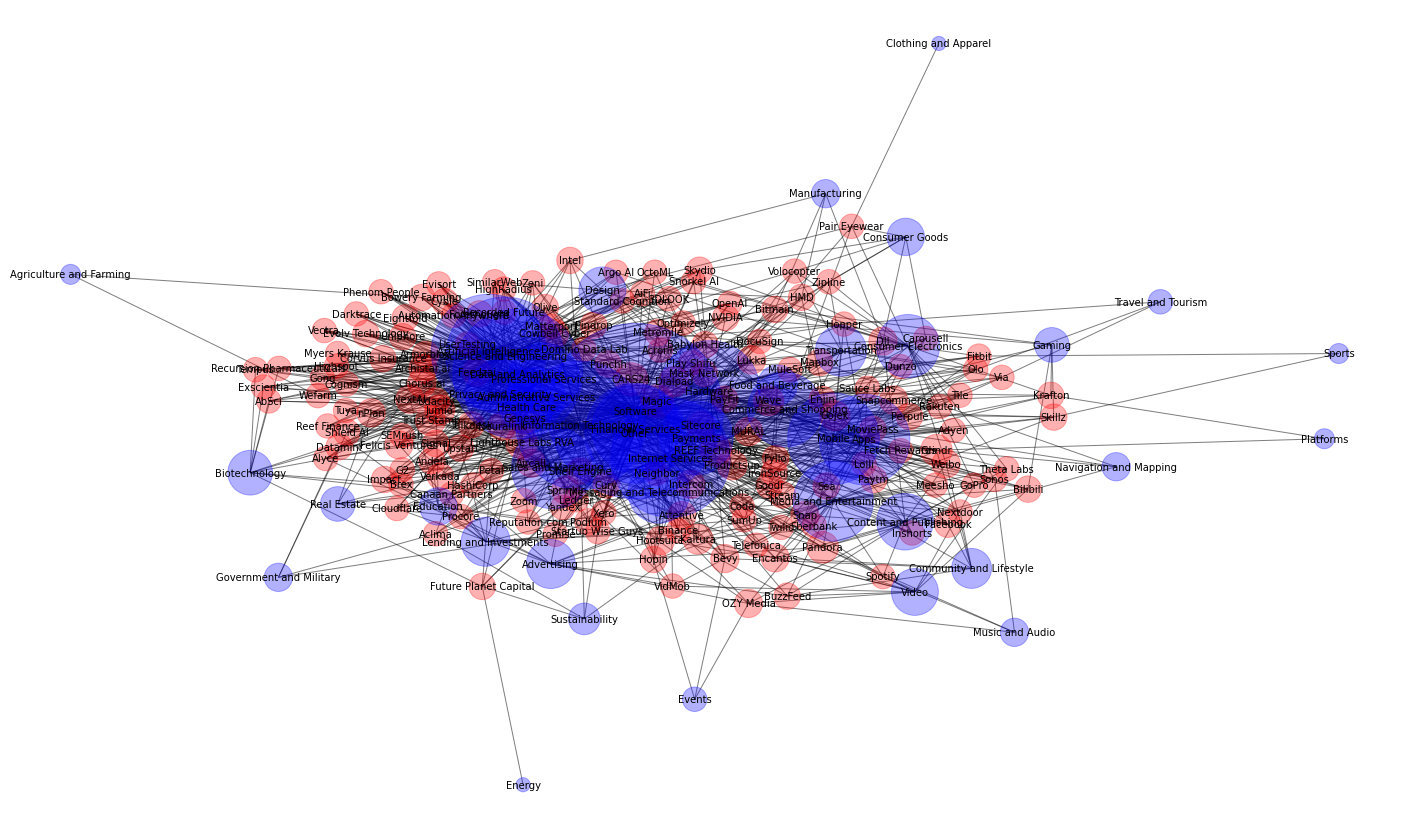

In [44]:
plot_bipartite_graph(B, small_degree=False)

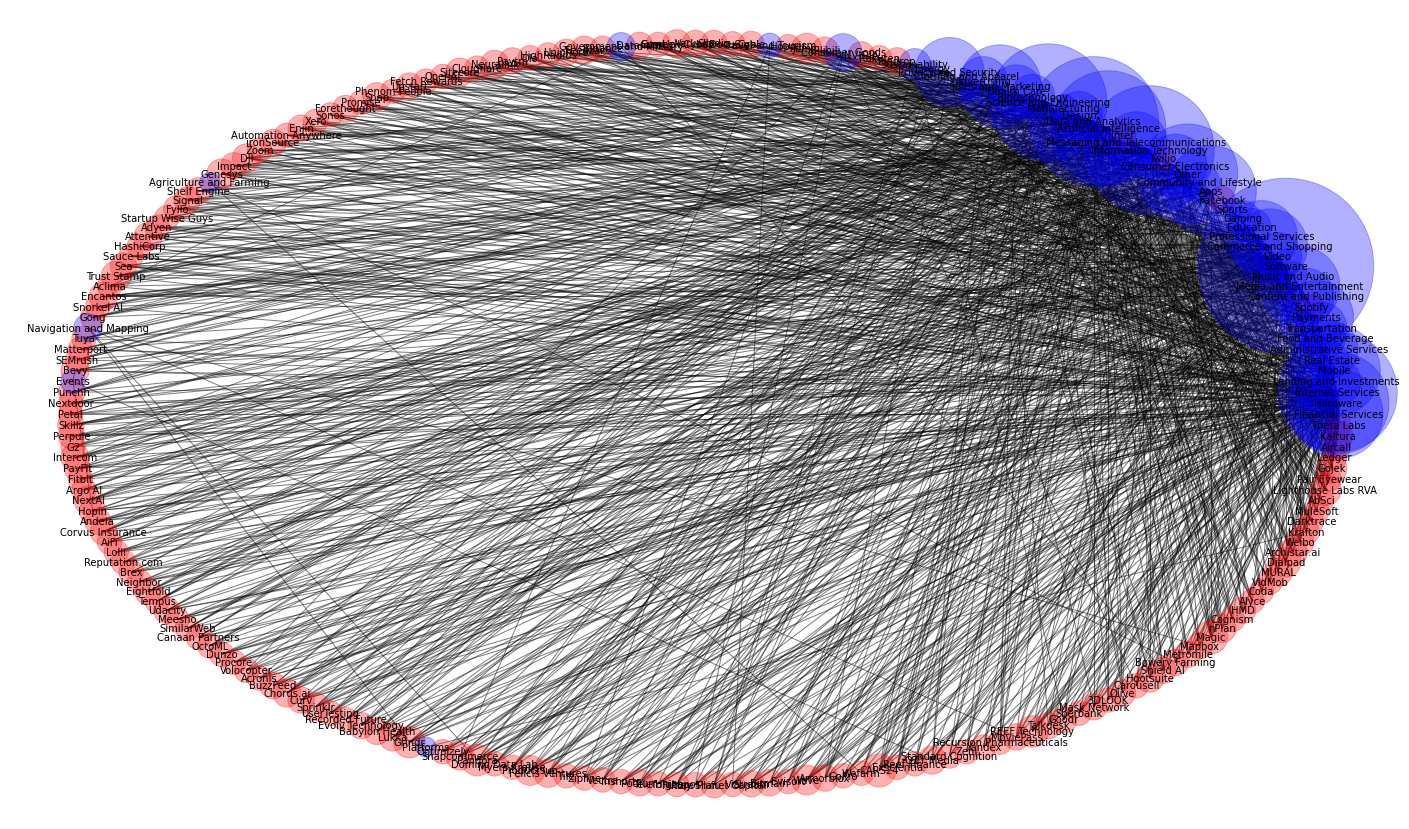

In [45]:
plot_bipartite_graph(B, small_degree=False, circular=True)

### Degree

The node degree is the number of edges adjacent to the node

In [46]:
[company_degree, tech_degree] = degree_bip(B)

In [47]:
print(f"We have {len(company_degree)} companies and {len(tech_degree)} technologies")

We have 999 companies and 47 technologies


In [48]:
# sort by value
company_degree_sorted = dict(sorted(company_degree.items(), key=lambda item: item[1], reverse=True))
tech_degree_sorted = dict(sorted(tech_degree.items(), key=lambda item: item[1], reverse=True))

# only maximum 
num_max = 10


# check we don't go out of range
if len(company_degree)<num_max or len(tech_degree)<num_max:
    minn = min(len(company_degree), len(tech_degree))
    num_max = minn-1

def limit_value(x, num_max_perc):
    return list(x.values())[num_max_perc]

company_degree_max = {k: company_degree_sorted[k] for k in list(company_degree_sorted.keys())[:num_max]}
tech_degree_max = {k: tech_degree_sorted[k] for k in list(tech_degree_sorted.keys())[:num_max]}


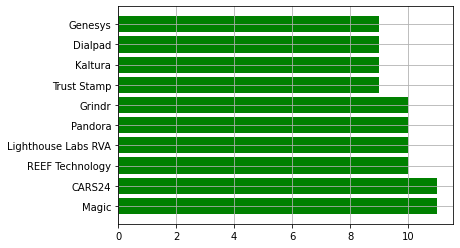

In [49]:
plt.barh(list(company_degree_max.keys()), company_degree_max.values(), color='g')
plt.grid(True)
plt.show()

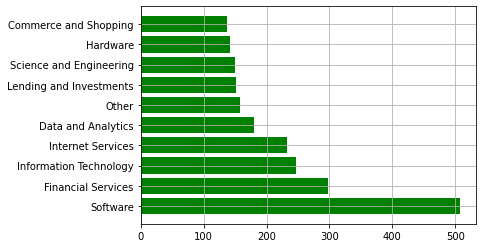

In [50]:
plt.barh(list(tech_degree_max.keys()), tech_degree_max.values(), color='g')
plt.grid(True)
plt.show()

In [51]:
# companies' degree 
dict_companies = insert_data_classes(dict_companies, dict(company_degree), 'degree')

In [52]:
# technologies' degree
dict_tech = insert_data_classes(dict_tech, dict(tech_degree), 'degree')

In [53]:
dict_companies['Skydio']

Company(id='c8bddc25-35e4-9d16-b00d-a8219360c1e7', name='Skydio', location={'city': 'Redwood City', 'region': 'California', 'country': 'United States', 'continent': 'North America'}, degree=7, rank_CB=0, rank_algo=0)

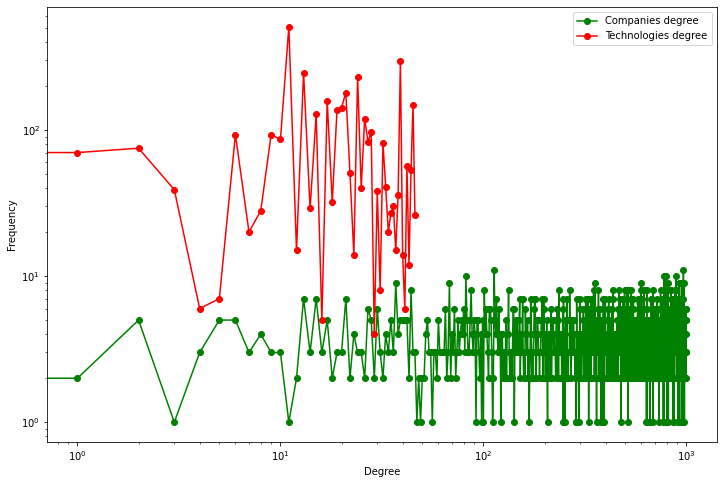

In [54]:
a = list(company_degree.values())
b = list(tech_degree.values())
degrees_a = range(len(a))
degrees_b = range(len(b))

m=0
plt.figure(figsize=(12, 8)) 
plt.loglog(degrees_a[m:], a,'go-', label='Companies degree') 
plt.loglog(degrees_b[m:], b,'ro-', label='Technologies degree') 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

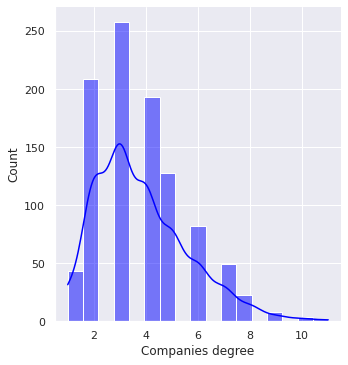

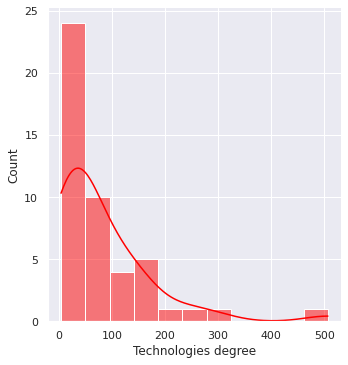

In [55]:
sns.set(style="darkgrid")
sns.displot(a, color="blue", label="Companies degree", kde=True)
plt.xlabel("Companies degree")
sns.displot(b, color="red", label="Technologies degree", kde=True)
plt.xlabel("Technologies degree")
plt.show()

### Rank

In [56]:
from networkx.algorithms.bipartite.matrix import biadjacency_matrix

In [57]:
set0 = extract_nodes(B, 0)
set1 = extract_nodes(B, 1)

# adjacency matrix of bipartite graph
adj_matrix = biadjacency_matrix(B, set0, set1)

In [58]:
adj_matrix_dense = adj_matrix.todense()

**Representation**

In [59]:
a = np.squeeze(np.asarray(adj_matrix_dense))
a.sum(axis=1)

array([ 1,  2,  5,  1,  3,  5,  5,  3,  4,  3,  3,  1,  2,  7,  3,  7,  3,
        5,  2,  3,  3,  7,  2,  4,  3,  3,  2,  6,  5,  2,  6,  3,  2,  4,
        3,  5,  3,  9,  4,  5,  5,  5,  5,  2,  8,  3,  3,  1,  2,  1,  2,
        2,  4,  5,  3,  3,  1,  3,  3,  2,  5,  3,  3,  3,  3,  6,  2,  3,
        9,  2,  4,  3,  6,  2,  3,  5,  3,  4,  5,  4,  6,  3, 10,  5,  3,
        3,  5,  8,  4,  3,  5,  4,  1,  5,  5,  3,  2,  4,  1,  5,  1,  8,
        4,  6,  4,  3,  2,  6,  6,  5,  3,  1,  2, 11,  5,  4,  7,  4,  3,
        6,  3,  4,  1,  4,  4,  2,  3,  2,  2,  5,  2,  4,  4,  8,  3,  2,
        2,  3,  2,  3,  6,  6,  1,  4,  5,  3,  5,  4,  3,  3,  5,  7,  2,
        4,  3,  3,  7,  3,  2,  3,  2,  6,  4,  4,  3,  5,  2,  3,  1,  2,
        3,  7,  4,  2,  3,  2,  3,  4,  6,  7,  7,  2,  2,  3,  5,  5,  4,
        3,  3,  2,  3,  3,  4,  5,  5,  7,  2,  2,  6,  7,  3,  4,  2,  4,
        2,  5,  2,  1,  4,  4,  4,  2,  4,  2,  3,  6,  2,  2,  4,  4,  4,
        5,  3,  4,  3,  3

In [60]:
company_degree

{'JFrog': 1,
 'D1 Capital Partners': 2,
 'Chainlink': 5,
 'Funding Circle': 1,
 'Jobandtalent': 3,
 'Coupa Software': 5,
 'SalesLoft': 5,
 'Bristol-Myers Squibb': 3,
 'Swiggy': 4,
 'Wayfair': 3,
 'Productiv': 3,
 'PlusDental': 1,
 'ZhenFund': 2,
 'Podium': 7,
 'Blockchain Capital': 3,
 'Olive': 7,
 'Augmedics': 3,
 'Graphcore': 5,
 'Doma': 2,
 'Careem': 3,
 'Carta': 3,
 'Punchh': 7,
 'Bain Capital Ventures': 2,
 'Chainalysis': 4,
 'Luminar': 3,
 'Pluralsight': 3,
 'Mogo': 2,
 'Wefarm': 6,
 'Medallia': 5,
 'Barclays': 2,
 'Cognism': 6,
 'OutSystems': 3,
 'Ginger': 2,
 'IonQ': 4,
 'BigCommerce': 3,
 'RingCentral': 5,
 'Just Eat Takeaway': 3,
 'Trust Stamp': 9,
 'TIRPORT': 4,
 'TigerGraph': 5,
 'Latch': 5,
 'View': 5,
 'AppLovin': 5,
 'DispatchHealth': 2,
 'Hootsuite': 8,
 'BlocPower': 3,
 'Pollinate Networks': 3,
 'DHL': 1,
 'SOSV': 2,
 'Morgan Stanley': 1,
 'General Catalyst': 2,
 'BoxGroup': 2,
 'Ideanomics': 4,
 'OpenSea': 5,
 'Zscaler': 3,
 'TAL Education Group': 3,
 'BetterUp': 1,
 

In [61]:
tech_degree

{'Lending and Investments': 152,
 'Privacy and Security': 70,
 'Professional Services': 75,
 'Real Estate': 39,
 'Government and Military': 6,
 'Agriculture and Farming': 7,
 'Artificial Intelligence': 93,
 'Video': 20,
 'Gaming': 28,
 'Payments': 93,
 'Transportation': 86,
 'Software': 507,
 'Energy': 15,
 'Information Technology': 247,
 'Manufacturing': 29,
 'Health Care': 128,
 'Natural Resources': 5,
 'Other': 158,
 'Content and Publishing': 32,
 'Commerce and Shopping': 137,
 'Hardware': 142,
 'Data and Analytics': 180,
 'Administrative Services': 51,
 'Clothing and Apparel': 14,
 'Internet Services': 232,
 'Food and Beverage': 40,
 'Mobile': 119,
 'Media and Entertainment': 83,
 'Sales and Marketing': 97,
 'Platforms': 4,
 'Community and Lifestyle': 38,
 'Navigation and Mapping': 8,
 'Apps': 81,
 'Education': 41,
 'Sustainability': 20,
 'Consumer Goods': 27,
 'Advertising': 30,
 'Sports': 15,
 'Design': 36,
 'Financial Services': 298,
 'Travel and Tourism': 14,
 'Events': 6,
 'Co

In [62]:
# M is the array version of the matrix adj_matrix_dense:
M = np.squeeze(np.asarray(adj_matrix_dense))

### Triangularize matrix

In [63]:
# triangularize matrix
def M_test_triangular(M):

    user_edits_sum = M.sum(axis=1).flatten()
    article_edits_sum = M.sum(axis=0).flatten()

    user_edits_order = user_edits_sum.argsort()
    article_edits_order = article_edits_sum.argsort()

    M_sorted = M[user_edits_order,:]

    if len(M_sorted.shape)>2: # the matrix in inside the first
        M_sorted = M_sorted[0] # so it becomes of size 2

    M_sorted_transponse = M_sorted.transpose()

    M_sorted_sorted_transponse = M_sorted_transponse[article_edits_order,:]

    if len(M_sorted_sorted_transponse.shape)>2: # the matrix in inside the first
        M_sorted_sorted_transponse = M_sorted_sorted_transponse[0] # so it becomes of size 2

    M_sorted_sorted = M_sorted_sorted_transponse.transpose()

    plt.figure(figsize=(10,10))
    plt.imshow(M_sorted_sorted, cmap=plt.cm.bone, interpolation='nearest')
    plt.xlabel("Technologies")
    plt.ylabel("Companies")
    plt.show()

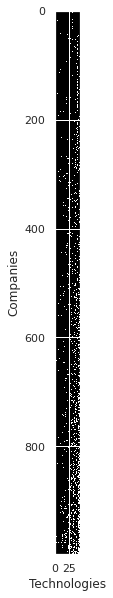

In [64]:
M_test_triangular(adj_matrix_dense)

From Maillart:

Ok now let's move onto our third and fourth operations on $M$ - getting some numeric rankings out of the matrix. Let us refresh ourselves on the equations from the literature. (Note variables _c_ and _p_, countries and products, translate to editors and article respectively): 

## Zeroth order scores

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

# Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{p=1}^{N_p}  G_{cp}(\beta) \,w^{(n)}_p (\alpha,\beta)\\[7pt]
w^{(n+1)}_p (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{pc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

## G - transition probability function
Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{cp}(\beta) = \frac{M_{cp} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c'p} k_{c'}^{-\beta}}\\[10pt]
G_{pc}(\alpha) = \frac{M_{cp} k_{p}^{-\alpha}}{\sum_{p' = 1}^{N_p} M_{cp'} k_{p'}^{-\alpha}}.\\\end{cases}

## Translating the mathematics into numpy
And now we implement the mathematics in python. Hopefully I got this right, it hasn't been independently verified. Additionally I implement $w$ as a `generator`, so you can go on for many iterations without chewing up too much memory. There is also a stream function that allows you get a specific iteration. And lastly a `find_convergence` function, that checks to see if the rankings haven't shifted for two consecutive iterations.

### Zero order score

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

In [65]:
def zero_order_score(M):
    
    # k_c = list(company_degree.values()) # companies
    # k_t = list(tech_degree.values()) # technologies
    
    k_c = M.sum(axis=1)
    k_t = M.sum(axis=0)


    return k_c, k_t

In [66]:
k_c, k_t = zero_order_score(M)

**Check of same sizes:**

In [67]:
len(k_c), len(k_t)

(999, 47)

In [68]:
print(f"We have {len(company_degree)} companies and {len(tech_degree)} technologies")

We have 999 companies and 47 technologies


### G - transition probability function

Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{ct}(\beta) = \frac{M_{ct} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c't} k_{c'}^{-\beta}}\\[10pt]
G_{tc}(\alpha) = \frac{M_{ct} k_{t}^{-\alpha}}{\sum_{t' = 1}^{N_t} M_{ct'} k_{t'}^{-\alpha}}.\\\end{cases}

In [69]:
def Gct_beta(M, c, t, k_c, beta):

    num = (M[c,t]) * (k_c[c] ** (- beta))

    # sum over the technologies
    M_t = M[:,t].flatten()
    k_c_beta = [x ** (-1 * beta) for x in k_c]

    den = float(np.dot(M_t, k_c_beta))
    
    return num/den

In [70]:
def Gtc_alpha(M, c, t, k_t, alpha):
    
    num = (M.T[t,c]) * (k_t[t] ** (- alpha))
    
    # sum over the companies
    M_c = M[c,:].flatten()
    k_t_alpha = [x ** (-1 * alpha) for x in k_t]
    
    type(M_c)
    type(k_t_alpha)
    
    den = float(np.dot(M_c, k_t_alpha))
    
    return num/den

In [71]:
def make_G_hat(M, alpha=1, beta=1):
    '''G hat is Markov chain of length 2
    Gct is a matrix to go from  companies to technologies and  
    Gtc is a matrix to go from technologies to companies'''
    
    # zero order score
    k_c, k_t = zero_order_score(M)
    
    # allocate space
    G_tc = np.zeros(shape=M.T.shape)
    G_ct = np.zeros(shape=M.shape)
    
    # Gct_beta
    for [c, t], val in np.ndenumerate(M):
        G_ct[c,t] = Gct_beta(M, c, t, k_c, beta)
    
    # Gtc_alpha
    for [t, c], val in np.ndenumerate(M.T):
        G_tc[t,c] = Gtc_alpha(M, c, t, k_t, alpha)
    
    return {'G_ct': G_ct, "G_tc" : G_tc}

### Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{t=1}^{N_p}  G_{ct}(\beta) \,w^{(n)}_t (\alpha,\beta)\\[7pt]
w^{(n+1)}_t (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{tc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

In [72]:
M = M
c = 3
t = 2
beta = 0.3
alpha = 0.4


In [73]:
def next_order_score(G_ct, G_tc, fitness_prev, ubiquity_prev):
    '''Generates w^(n+1) from w^n
    '''
    
    fitness_next = np.sum( G_ct * ubiquity_prev, axis=1 )
    ubiquity_next = np.sum( G_tc * fitness_prev, axis=1 )
    
    return fitness_next, ubiquity_next

In [74]:
def generator_order_w(M, alpha, beta):
    """Generates w_t^{n+1} and w_c^{n+1}
    
    fitness_next = w_t next
    ubliq_next = w_c next
    
    """
    
    # transition probabilities
    G_hat = make_G_hat(M, alpha, beta)
    G_ct = G_hat['G_ct']
    G_tc = G_hat['G_tc']
    
    # strating point
    fitness_0, ubiquity_0  = zero_order_score(M)
    
    fitness_next = fitness_0
    ubiquity_next = ubiquity_0
    i = 0
    
    while True:
        
        fitness_prev = fitness_next
        ubiquity_prev = ubiquity_next
        i += 1
        
        fitness_next, ubiquity_next = next_order_score(G_ct, G_tc, fitness_prev, ubiquity_prev)
        
        yield {'iteration':i, 'fitness': fitness_next, 'ubiquity': ubiquity_next}
        

In [75]:
def w_stream(M, i, alpha, beta):
    """get a specific itelration of w, 
    but in a memory safe way so we can calculate many generations"""
    
    if i < 0:
        raise ValueError
        
    for j in generator_order_w(M, alpha, beta):
        if j[0] == i:
            return {'fitness': j[1], 'ubiquity': j[2]}
            break

In [76]:
def find_convergence(M, alpha, beta, fit_or_ubiq, do_plot=False,):
    '''finds the convergence point (or gives up after 1000 iterations)'''
    
    # technologies or company
    if fit_or_ubiq == 'fitness':
        Mshape = M.shape[0]
        name = 'technologies'
    elif fit_or_ubiq == 'ubiquity':
        name = 'companies'
        Mshape = M.shape[1]
    
    rankings = list()
    scores = list()
    
    prev_rankdata = np.zeros(Mshape)
    iteration = 0
    
    weights = generator_order_w(M, alpha, beta)

    for stream_data in weights:
        
        iteration = stream_data['iteration']
        
        data = stream_data[fit_or_ubiq] # weights
        
        rankdata = data.argsort().argsort()
        
        #print(iteration, data, rankdata)
        
        # test for convergence
        if np.equal(rankdata,prev_rankdata).all(): # no changes
            break
        if iteration == 1000: # max limit
            break
        else: # go ahead
            rankings.append(rankdata)
            scores.append(data)
            prev_rankdata = rankdata
    
    # plot:
    if do_plot:
        plt.figure(figsize=(10, 10))
        plt.xlabel('Iteration')
        plt.ylabel('Rank, higher is better')
        plt.title(f'Rank Evolution of {name}')
        p = plt.semilogx(range(1,iteration), rankings, '-,', alpha=0.5)
        
    return {fit_or_ubiq:scores[-1], 'iteration':iteration}

In [ ]:
convergence = find_convergence(M, alpha=0.5, beta=0.5, fit_or_ubiq='fitness', do_plot=True)

In [ ]:
convergence['iteration']

We also know from Caldarelli et al. that there is an analytic formulation to the recursive procedure. So if you want to save some (a lot) processing and just know the end result we can use:

## Analytic solution

\begin{cases}
w^{*}_e (\alpha,\beta) = (\sum_{a=1}^{N_a} M_{ea}k_{a}^{-\alpha})k_{e}^{-\beta} \\
w^{*}_a (\alpha,\beta) = (\sum_{e=1}^{N_e}  M_{ea}k_{e}^{-\beta})k_{a}^{-\alpha}\\
\end{cases}

And again in python:

In [ ]:
def w_star_analytic(M, alpha, beta, w_star_type):
    k_c  = M.sum(axis=1) #aka k_c summing over the rows
    k_p = M.sum(axis=0) #aka k_p summering over the columns
    
    A = 1
    B = 1
    
    def Gcp_denominateur(M, p, k_c, beta):
        M_p = M[:,p]
        k_c_beta = k_c ** (-1 * beta)
        return np.dot(M_p, k_c_beta)
    
    def Gpc_denominateur(M, c, k_p, alpha):
        M_c = M[c,:]
        k_p_alpha = k_p ** (-1 * alpha)
        return np.dot(M_c, k_p_alpha)
    
    if w_star_type == 'w_star_c':
        w_star_c = np.zeros(shape=M.shape[0])

        for c in range(M.shape[0]):
            summand = Gpc_denominateur(M, c, k_p, alpha)
            k_beta = (k_c[c] ** (-1 * beta))
            w_star_c[c] = A * summand * k_beta

        return w_star_c
    
    elif w_star_type == 'w_star_p':
        w_star_p = np.zeros(shape=M.shape[1])
    
        for p in range(M.shape[1]):
            summand = Gcp_denominateur(M, p, k_c, beta)
            k_alpha = (k_p[p] ** (-1 * alpha))
            w_star_p[p] = B * summand * k_alpha
    
        return w_star_p

In [ ]:
w_scores = w_star_analytic(M, alpha=0.5, beta=0.5, w_star_type='w_star_c')
i = 0
dict_comp_rank = {}

for c in dict_companies.keys():
    c_rank = w_scores[i]
    dict_comp_rank[c] = c_rank
    i = i+1
    
dict_comp_rank

In [ ]:
w_ranks = {name: w_scores[pos] for name, pos in  }
#sort
w_ranks_sorted = sorted(w_ranks.iteritems(), key=operator.itemgetter(1))

#or use pandas
w_scores_df = pd.DataFrame.from_dict(w_ranks, orient='index')
w_scores_df.columns = ['w_score']
w_scores_df.sort(columns=['w_score'], ascending=False).head()

In [65]:
w_scores

NameError: name 'w_scores' is not defined

In [ ]:
company_degree

In [ ]:
dict_companies